In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import os

Loaded dataset with 6090 total images, using 3045 (50%).
Training samples: 2589, Validation samples: 456
Classes: ['empty', 'not_empty']


/home/ezra/anaconda3/envs/DS/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ezra/anaconda3/envs/DS/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 loss 0.0410 val_acc 1.0000 prec 1.0000 rec 1.0000 f1 1.0000 roc 1.0


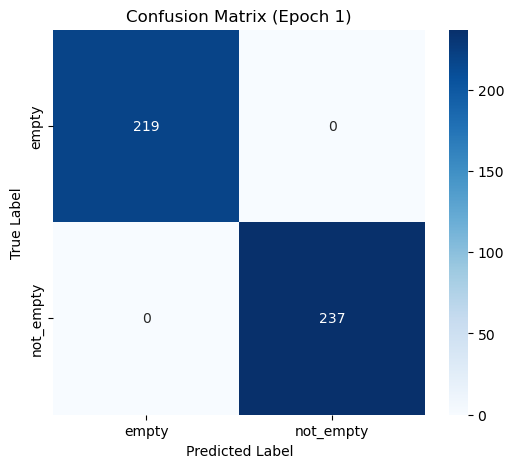

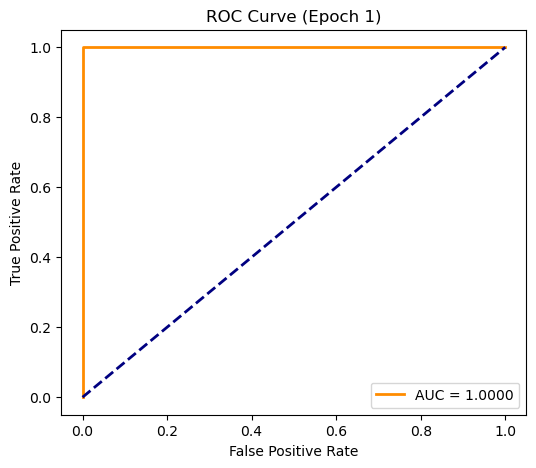

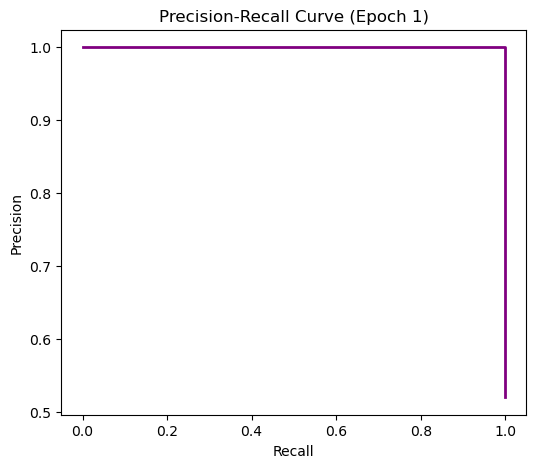

✅ Saved best model.
Epoch 2 loss 0.0011 val_acc 1.0000 prec 1.0000 rec 1.0000 f1 1.0000 roc 1.0


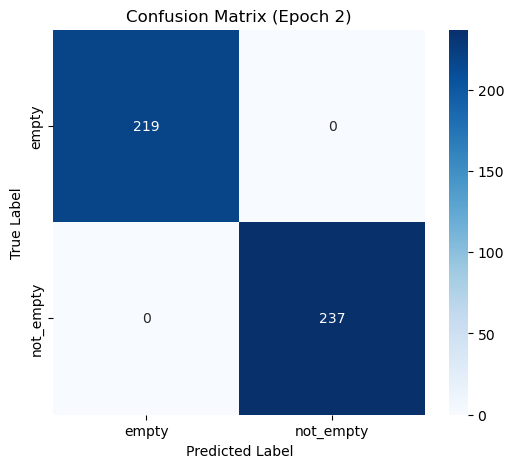

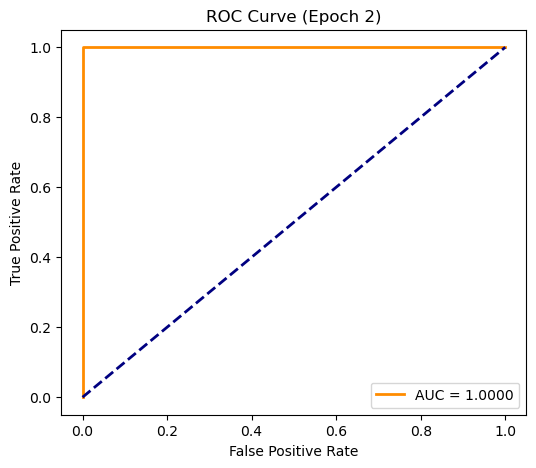

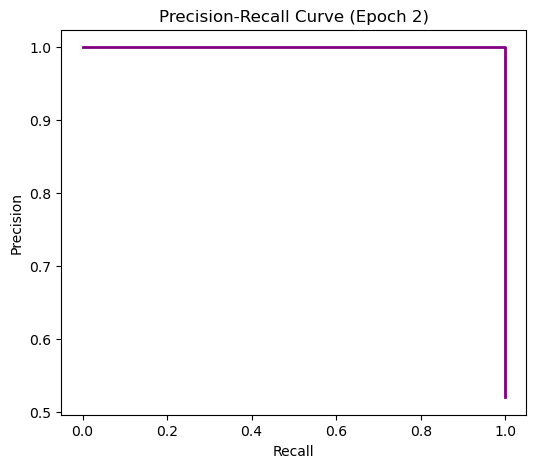

Epoch 3 loss 0.0009 val_acc 1.0000 prec 1.0000 rec 1.0000 f1 1.0000 roc 1.0


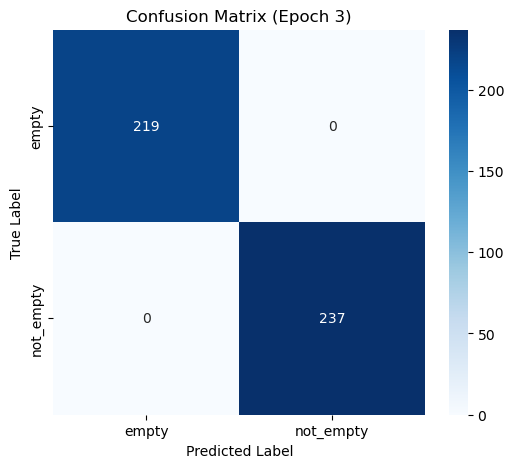

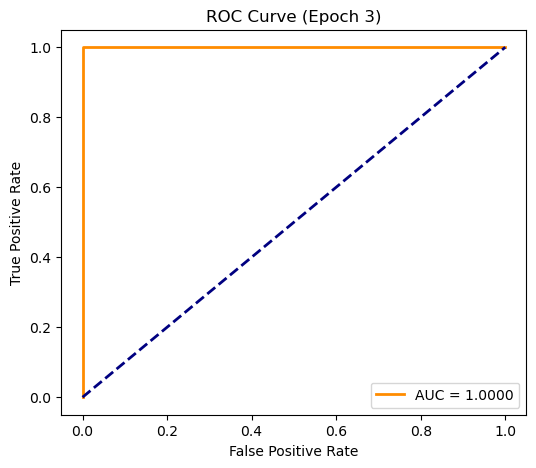

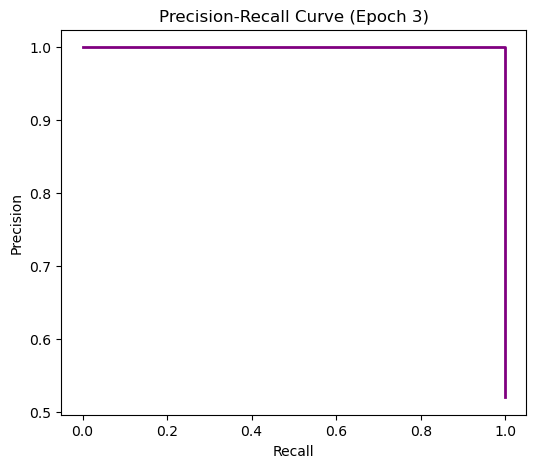

Epoch 4 loss 0.0009 val_acc 1.0000 prec 1.0000 rec 1.0000 f1 1.0000 roc 1.0


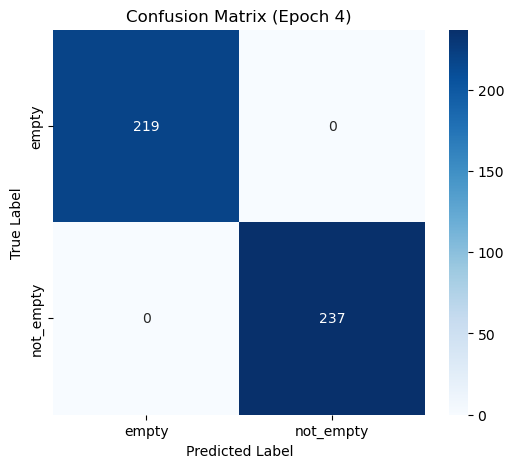

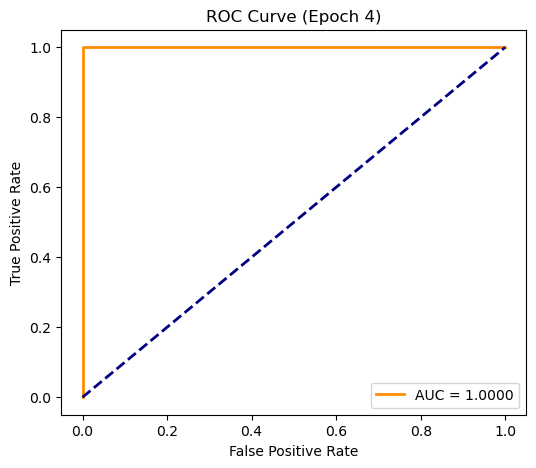

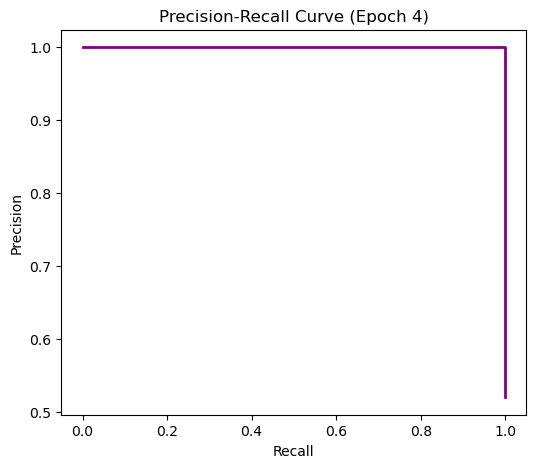

Epoch 5 loss 0.0024 val_acc 1.0000 prec 1.0000 rec 1.0000 f1 1.0000 roc 1.0


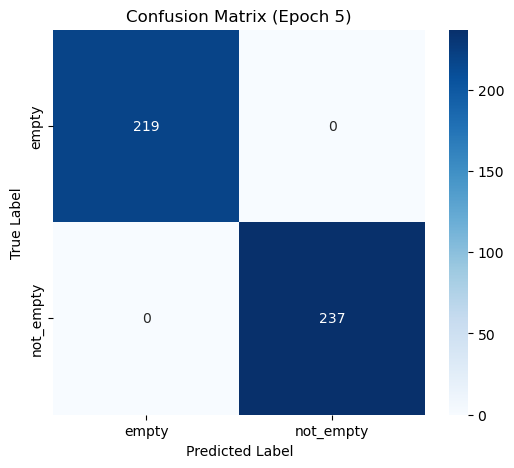

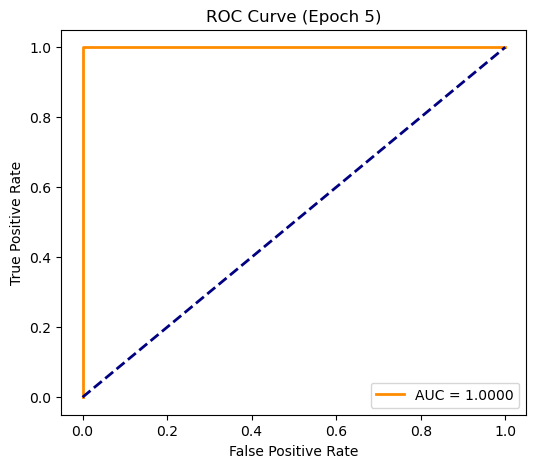

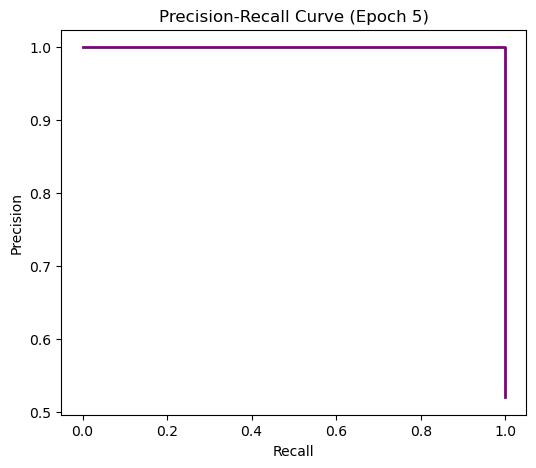

Epoch 6 loss 0.0005 val_acc 1.0000 prec 1.0000 rec 1.0000 f1 1.0000 roc 1.0


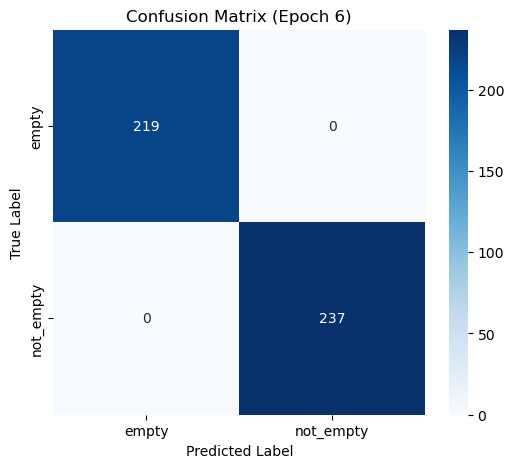

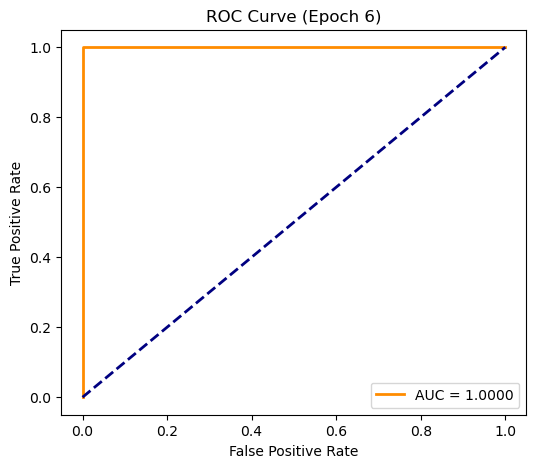

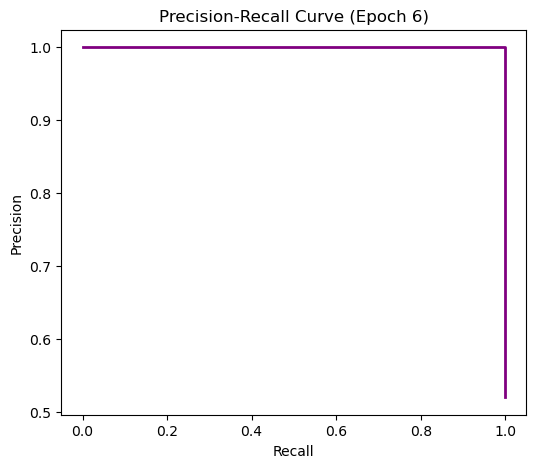

Epoch 7 loss 0.0003 val_acc 1.0000 prec 1.0000 rec 1.0000 f1 1.0000 roc 1.0


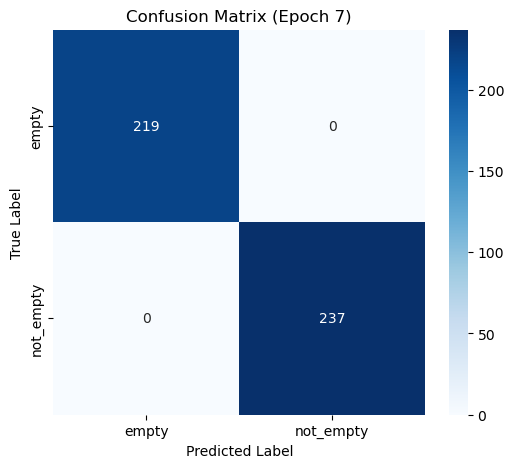

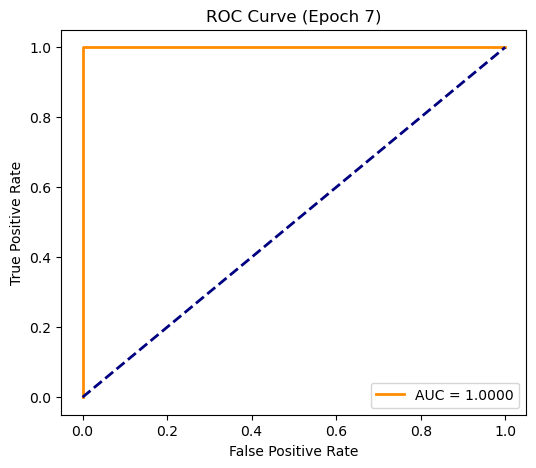

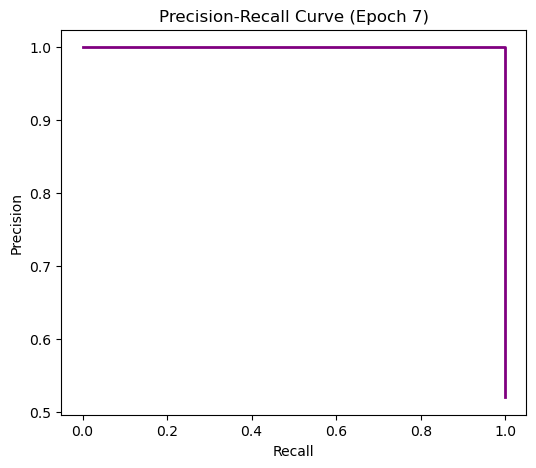

Epoch 8 loss 0.0001 val_acc 1.0000 prec 1.0000 rec 1.0000 f1 1.0000 roc 1.0


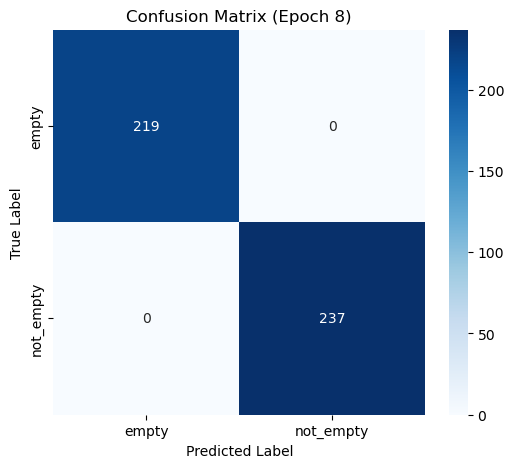

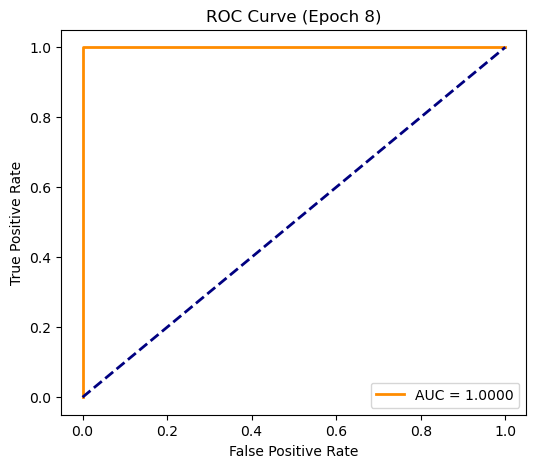

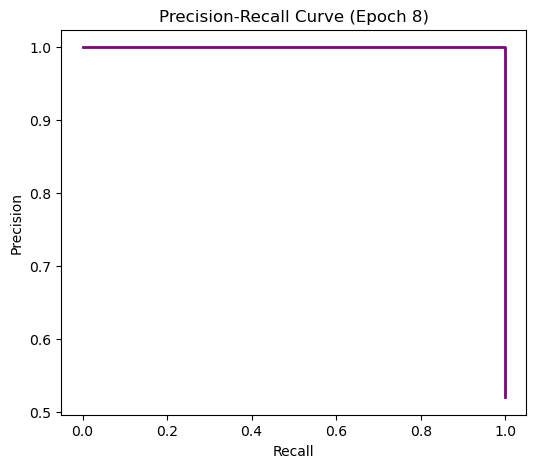

Epoch 9 loss 0.0011 val_acc 1.0000 prec 1.0000 rec 1.0000 f1 1.0000 roc 1.0


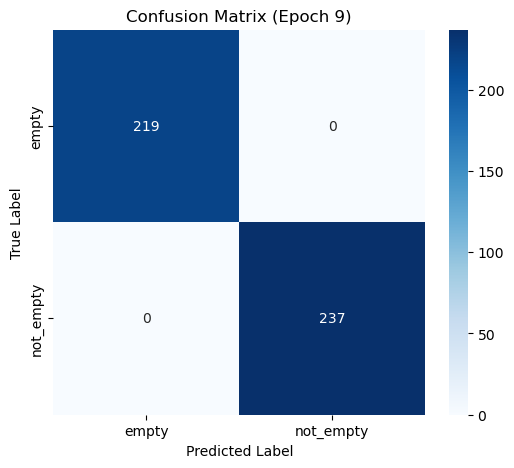

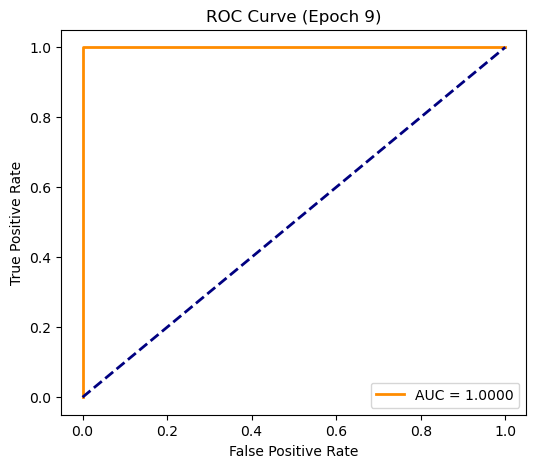

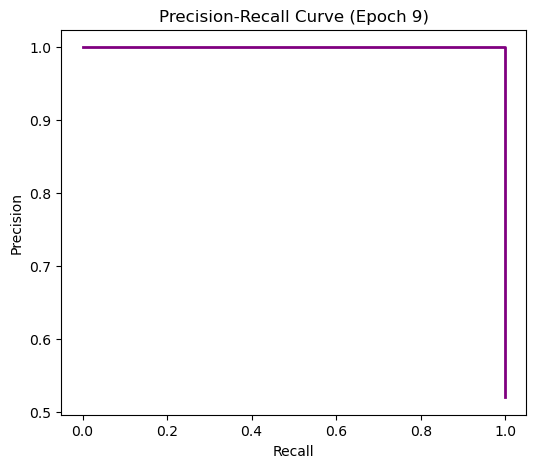

Epoch 10 loss 0.0003 val_acc 1.0000 prec 1.0000 rec 1.0000 f1 1.0000 roc 1.0


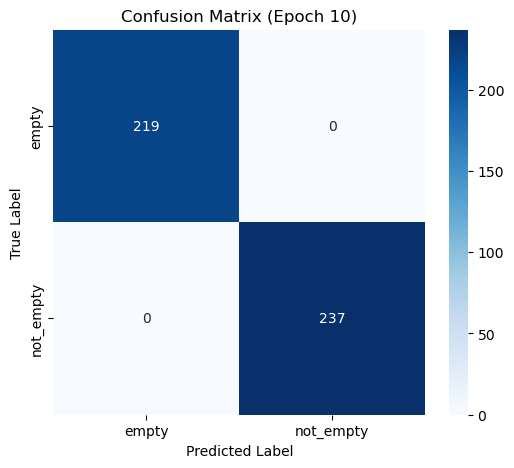

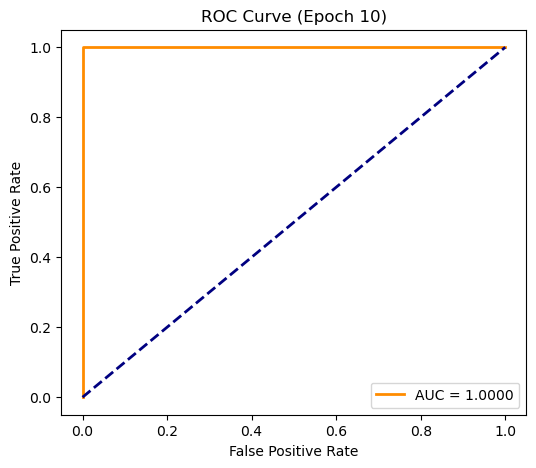

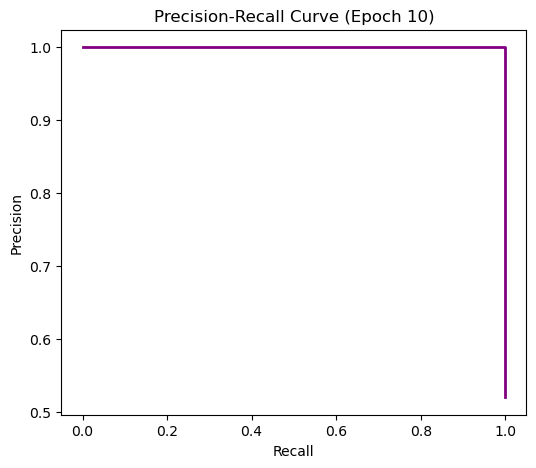

Epoch 11 loss 0.0002 val_acc 1.0000 prec 1.0000 rec 1.0000 f1 1.0000 roc 1.0


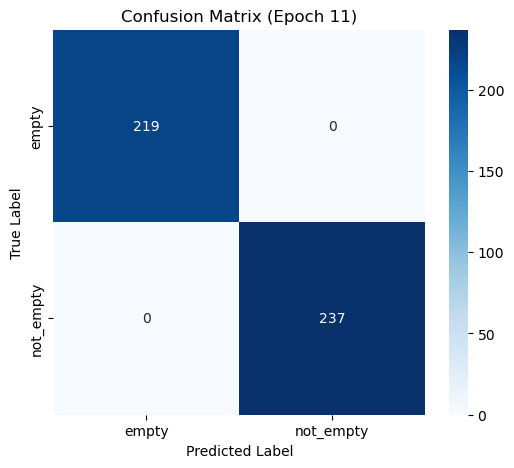

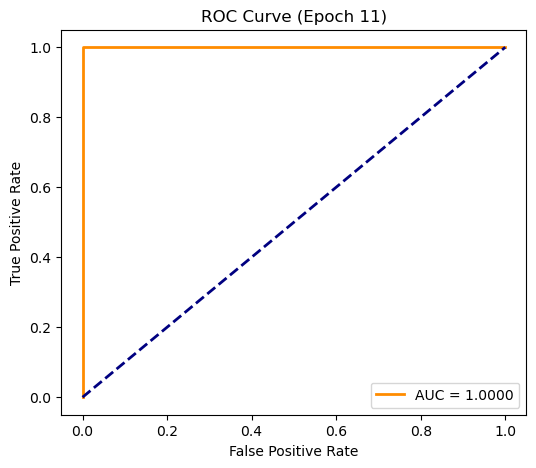

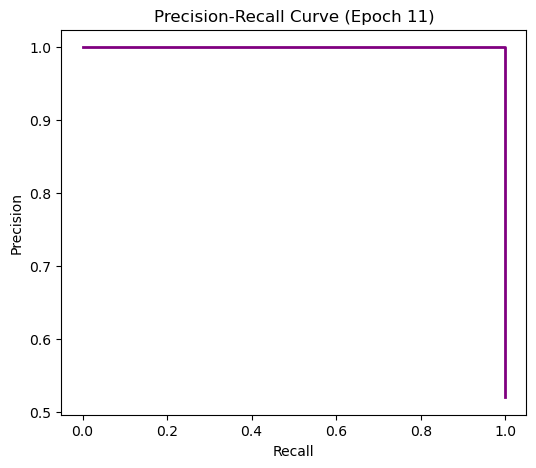

Epoch 12 loss 0.0001 val_acc 1.0000 prec 1.0000 rec 1.0000 f1 1.0000 roc 1.0


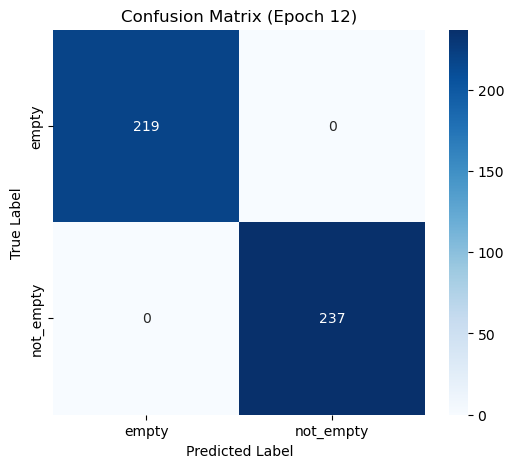

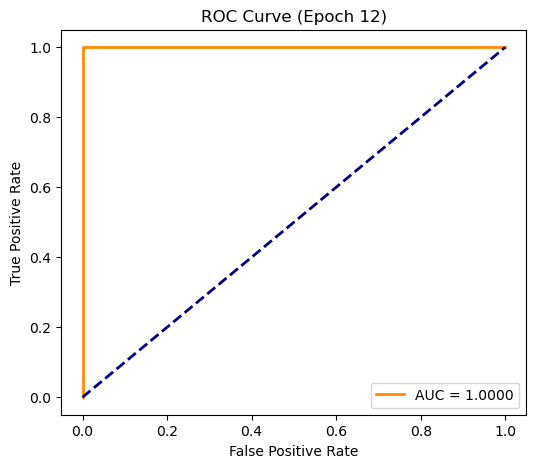

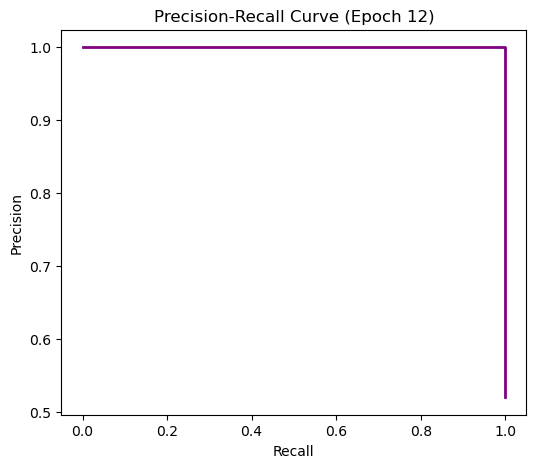

Epoch 13 loss 0.0000 val_acc 1.0000 prec 1.0000 rec 1.0000 f1 1.0000 roc 1.0


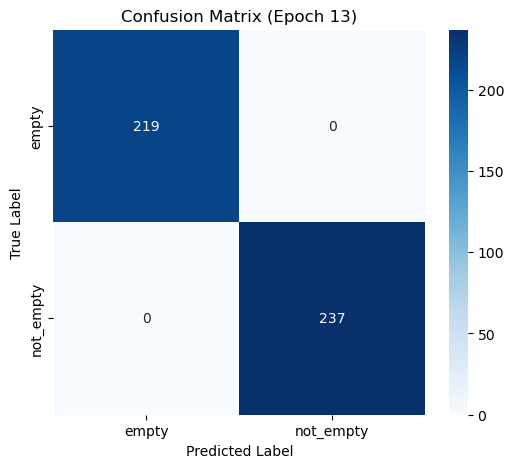

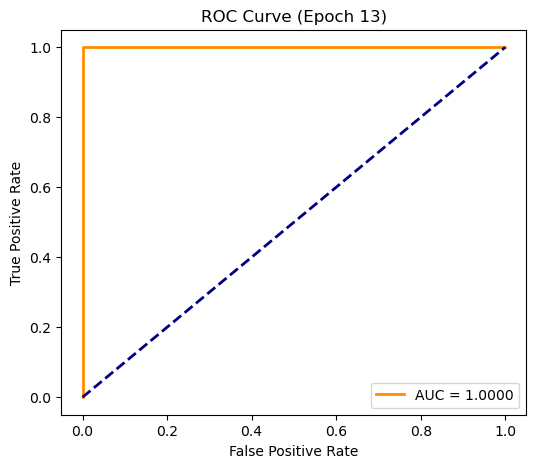

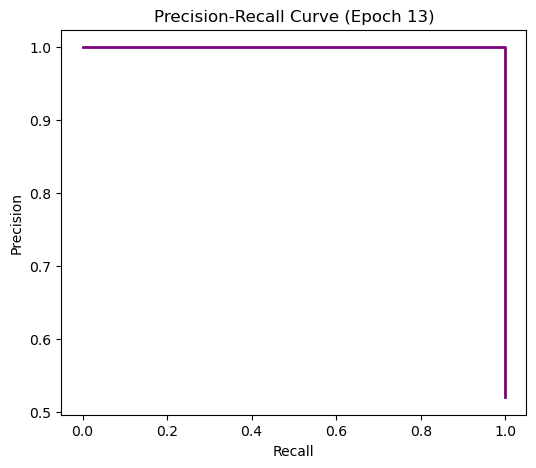

Epoch 14 loss 0.0001 val_acc 1.0000 prec 1.0000 rec 1.0000 f1 1.0000 roc 1.0


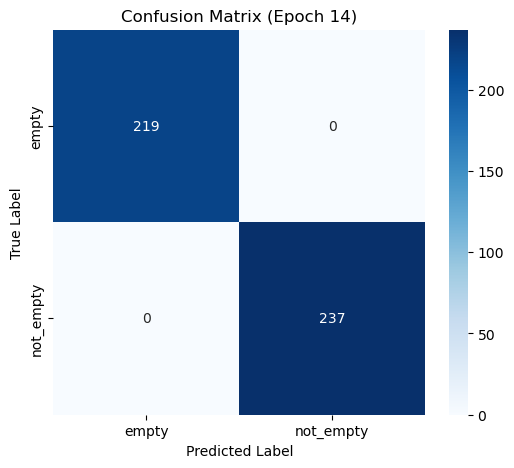

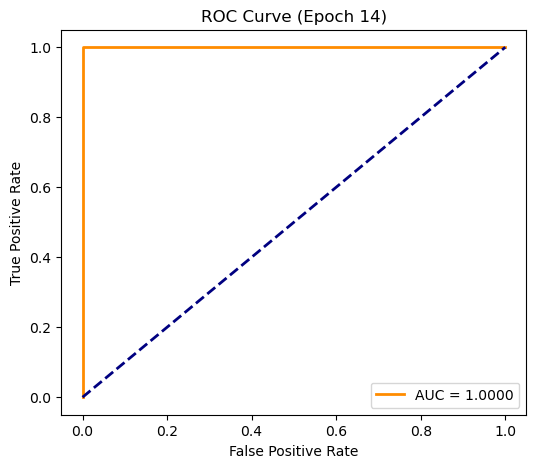

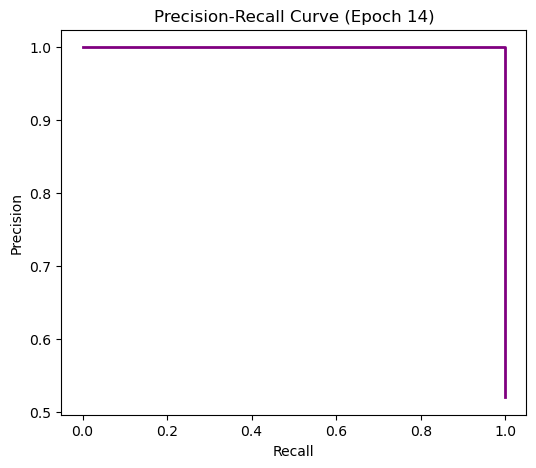

Epoch 15 loss 0.0001 val_acc 1.0000 prec 1.0000 rec 1.0000 f1 1.0000 roc 1.0


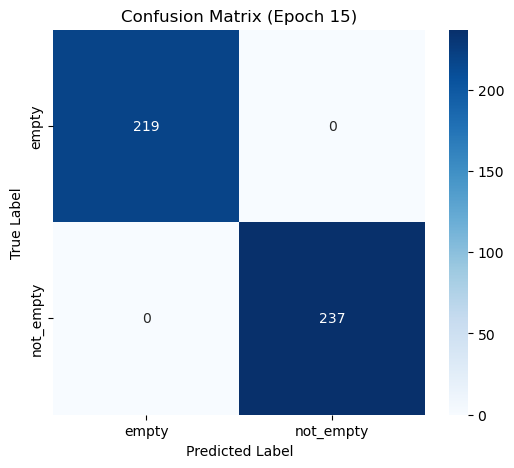

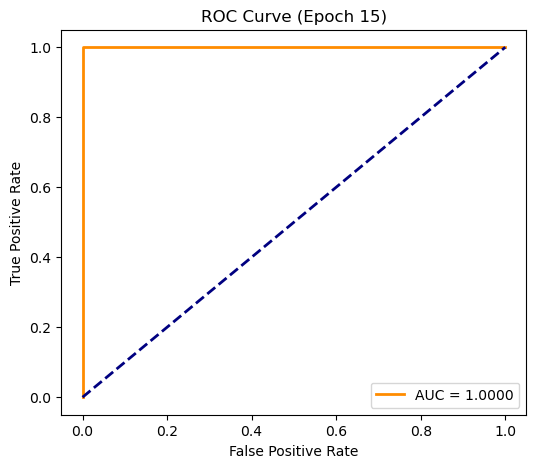

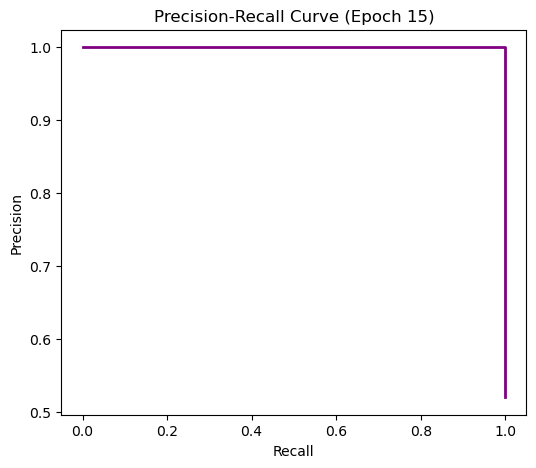

Epoch 16 loss 0.0001 val_acc 1.0000 prec 1.0000 rec 1.0000 f1 1.0000 roc 1.0


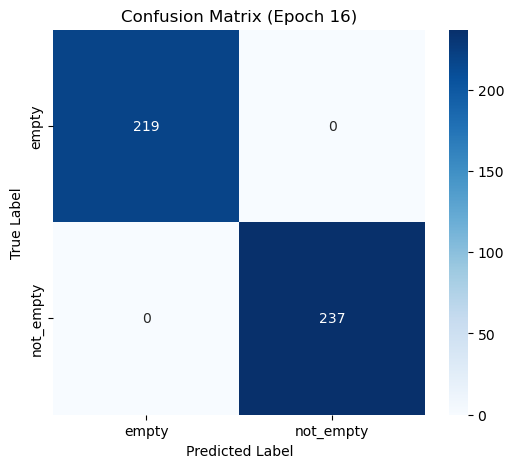

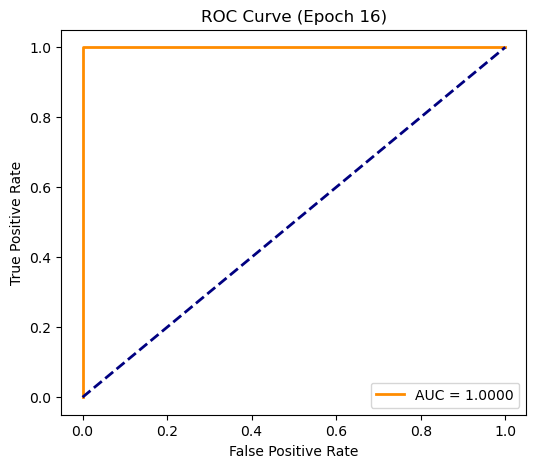

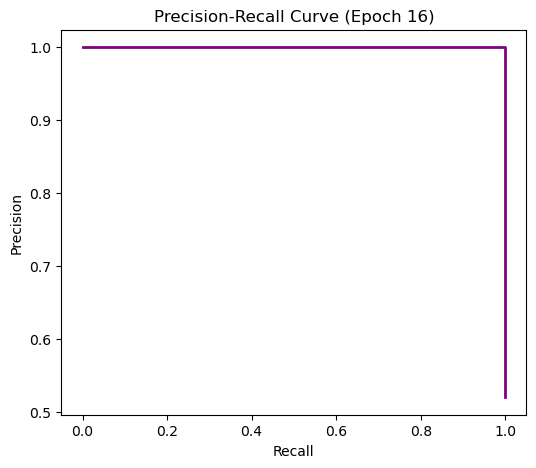

Epoch 17 loss 0.0001 val_acc 1.0000 prec 1.0000 rec 1.0000 f1 1.0000 roc 1.0


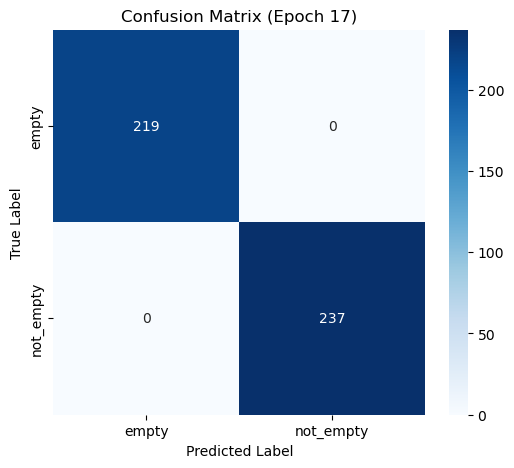

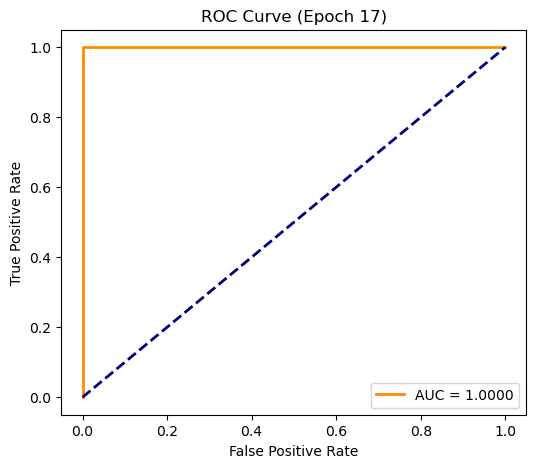

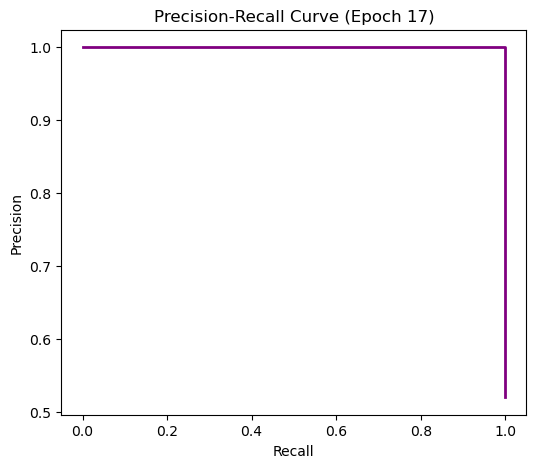

Epoch 18 loss 0.0001 val_acc 1.0000 prec 1.0000 rec 1.0000 f1 1.0000 roc 1.0


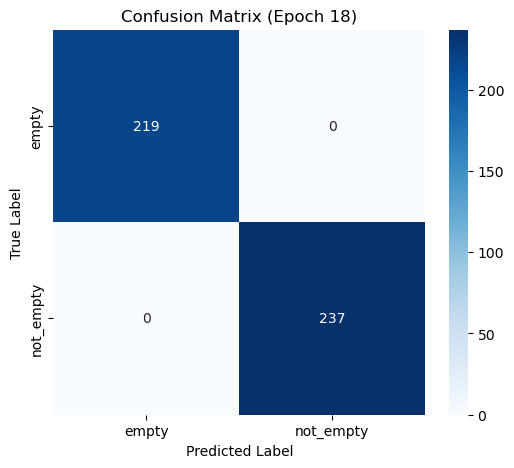

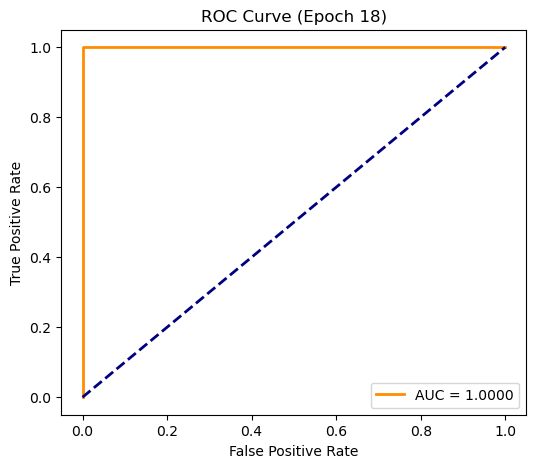

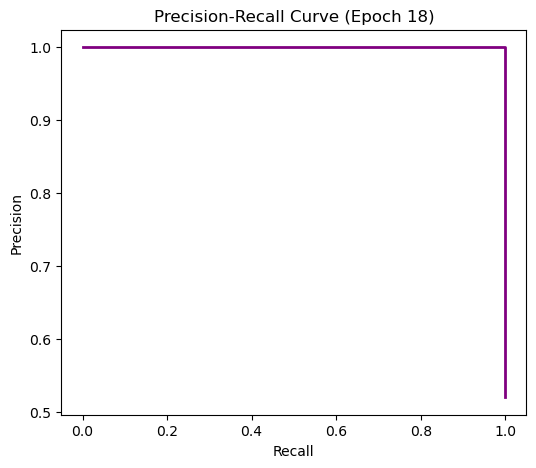

Epoch 19 loss 0.0001 val_acc 1.0000 prec 1.0000 rec 1.0000 f1 1.0000 roc 1.0


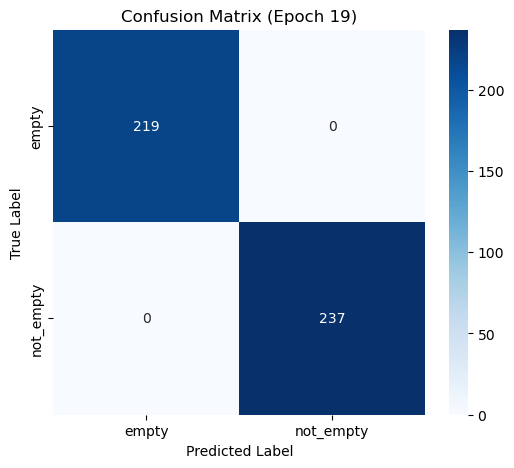

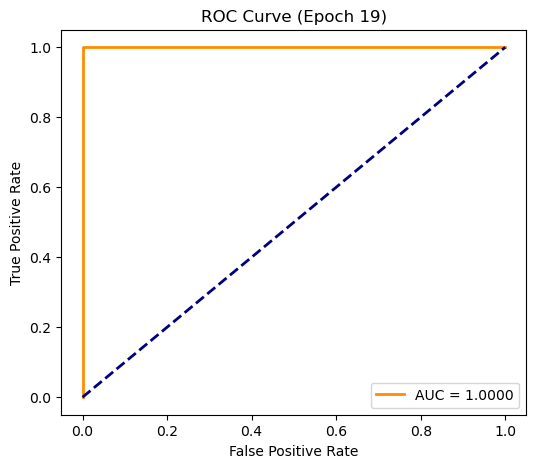

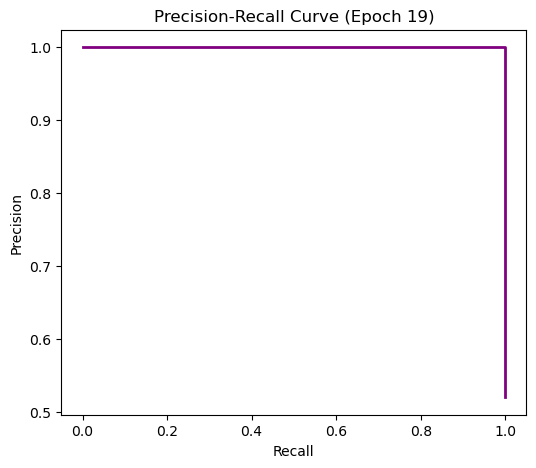

Epoch 20 loss 0.0001 val_acc 1.0000 prec 1.0000 rec 1.0000 f1 1.0000 roc 1.0


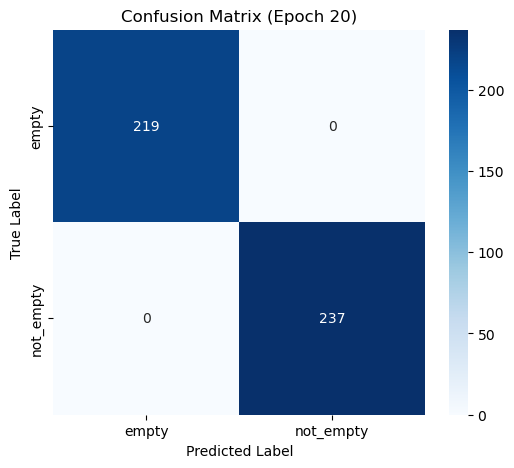

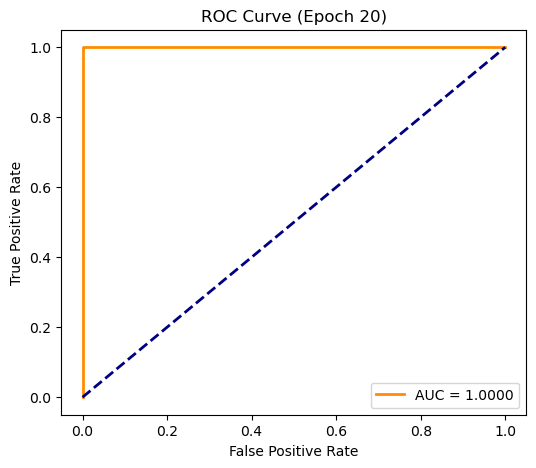

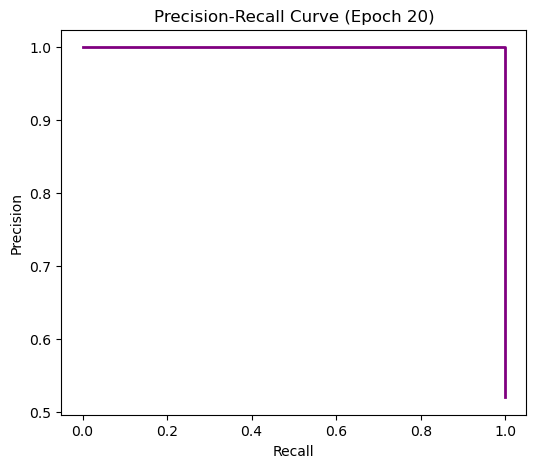

Training complete. Best val F1: 1.0


In [15]:
# -----------------------------
# 1. Transforms
# -----------------------------
def get_transforms(train=True):
    if train:
        return transforms.Compose([
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

# -----------------------------
# 2. Model
# -----------------------------
def get_model(device='cuda'):
    model = models.mobilenet_v2(pretrained=True)
    in_f = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_f, 2)   # 2 classes: empty, not_empty
    return model.to(device)

# -----------------------------
# 3. Training Loop + Evaluation Visuals
# -----------------------------
def train(args):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Load dataset
    full_ds = datasets.ImageFolder(root=args.data_root, transform=get_transforms(train=True))

    # Use only 50% of dataset
    half_size = len(full_ds) // 2
    indices = torch.randperm(len(full_ds))[:half_size]
    subset_ds = torch.utils.data.Subset(full_ds, indices)

    # Train/val split (85/15)
    val_ratio = 0.15
    n_val = int(len(subset_ds) * val_ratio)
    n_train = len(subset_ds) - n_val
    train_ds, val_ds = random_split(subset_ds, [n_train, n_val], generator=torch.Generator().manual_seed(42))
    val_ds.dataset.dataset.transform = get_transforms(train=False)

    # Loaders
    train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=args.batch_size, shuffle=False, num_workers=4)

    print(f"Loaded dataset with {len(full_ds)} total images, using {len(subset_ds)} (50%).")
    print(f"Training samples: {len(train_ds)}, Validation samples: {len(val_ds)}")
    print(f"Classes: {full_ds.classes}")

    model = get_model(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

    best_f1 = 0.0
    class_names = full_ds.classes

    for epoch in range(1, args.epochs + 1):
        # ---- Training ----
        model.train()
        losses = []
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        avg_loss = np.mean(losses) if losses else 0

        # ---- Validation ----
        model.eval()
        y_true, y_pred, y_score = [], [], []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device)
                logits = model(imgs)
                probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
                preds = np.argmax(logits.cpu().numpy(), axis=1)
                y_true.extend(labels.numpy().tolist())
                y_pred.extend(preds.tolist())
                y_score.extend(probs.tolist())

        acc = accuracy_score(y_true, y_pred) if y_true else 0
        prec, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='binary', zero_division=0, pos_label=1
        )
        try:
            roc = roc_auc_score(y_true, y_score)
        except:
            roc = None

        print(f"Epoch {epoch} loss {avg_loss:.4f} val_acc {acc:.4f} prec {prec:.4f} rec {recall:.4f} f1 {f1:.4f} roc {roc}")
        scheduler.step(1 - f1)

        # ---- Visuals ----
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.title(f"Confusion Matrix (Epoch {epoch})")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.show()

        if len(set(y_true)) == 2:  # ROC + PR curve for binary classification
            fpr, tpr, _ = roc_curve(y_true, y_score)
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(6, 5))
            plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.4f}")
            plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC Curve (Epoch {epoch})")
            plt.legend(loc="lower right")
            plt.show()

            from sklearn.metrics import precision_recall_curve
            precision, recall, _ = precision_recall_curve(y_true, y_score)
            plt.figure(figsize=(6, 5))
            plt.plot(recall, precision, lw=2, color="purple")
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title(f"Precision-Recall Curve (Epoch {epoch})")
            plt.show()

        if f1 > best_f1:
            best_f1 = f1
            os.makedirs(args.checkpoint_dir, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(args.checkpoint_dir, 'best_model.pth'))
            print("✅ Saved best model.")

    print("Training complete. Best val F1:", best_f1)

# -----------------------------
# 4. Entry Point
# -----------------------------
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_root', default='data/clf-data')
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--epochs', type=int, default=20)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--checkpoint_dir', default='checkpoints')
    args, unknown = parser.parse_known_args()

    train(args)
